In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from Utils import Utils
from Constants import Constants
from PS_Matching import PS_Matching
from Propensity_socre_network import Propensity_socre_network
from Utils import Utils

from GAN import Generator, Discriminator
from sklearn.neighbors import NearestNeighbors

from GAN_Manager import GAN_Manager
from Utils import Utils

from matplotlib import pyplot
from torch.autograd.variable import Variable
from collections import OrderedDict

In [2]:

from DCN import DCN

class DCN_network_1:    
    def train(self, train_parameters, device, train_mode=Constants.DCN_TRAIN_PD):
        epochs = train_parameters["epochs"]
        treated_batch_size = train_parameters["treated_batch_size"]
        control_batch_size = train_parameters["control_batch_size"]
        lr = train_parameters["lr"]
        shuffle = train_parameters["shuffle"]
        model_save_path = train_parameters["model_save_path"].format(epochs, lr)
        treated_set_train = train_parameters["treated_set_train"]
        control_set_train = train_parameters["control_set_train"]

        input_nodes = train_parameters["input_nodes"]

        print("Saved model path: {0}".format(model_save_path))

        treated_data_loader_train = torch.utils.data.DataLoader(treated_set_train,
                                                                batch_size=treated_batch_size,
                                                                shuffle=shuffle,
                                                                num_workers=1)

        control_data_loader_train = torch.utils.data.DataLoader(control_set_train,
                                                                batch_size=control_batch_size,
                                                                shuffle=shuffle,
                                                                num_workers=1)

        network = DCN(training_mode=train_mode,
                      input_nodes=input_nodes).to(device)
        optimizer = optim.Adam(network.parameters(), lr=lr)
        lossF = nn.MSELoss()
        min_loss = 100000.0
        dataset_loss = 0.0
        print(".. Training started ..")
        print(device)
        for epoch in range(epochs):
            network.train()
            total_loss = 0
            train_set_size = 0

            if epoch % 2 == 0:
                dataset_loss = 0
                # train treated
                network.hidden1_Y1.weight.requires_grad = True
                network.hidden1_Y1.bias.requires_grad = True
                network.hidden2_Y1.weight.requires_grad = True
                network.hidden2_Y1.bias.requires_grad = True
                network.out_Y1.weight.requires_grad = True
                network.out_Y1.bias.requires_grad = True

                network.hidden1_Y0.weight.requires_grad = False
                network.hidden1_Y0.bias.requires_grad = False
                network.hidden2_Y0.weight.requires_grad = False
                network.hidden2_Y0.bias.requires_grad = False
                network.out_Y0.weight.requires_grad = False
                network.out_Y0.bias.requires_grad = False

                for batch in treated_data_loader_train:
                    covariates_X, ps_score, y_f, y_cf = batch
                    covariates_X = covariates_X.to(device)
                    ps_score = ps_score.squeeze().to(device)

                    train_set_size += covariates_X.size(0)
                    treatment_pred = network(covariates_X, ps_score)
                    # treatment_pred[0] -> y1
                    # treatment_pred[1] -> y0
                    yf_predicted = treatment_pred[0]
                    if torch.cuda.is_available():
                        loss = lossF(yf_predicted.float().cuda(),
                                     y_f.float().cuda()).to(device)
                    else:
                        loss = lossF(yf_predicted.float(),
                                     y_f.float()).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                dataset_loss = total_loss

            elif epoch % 2 == 1:
                # train controlled
                network.hidden1_Y1.weight.requires_grad = False
                network.hidden1_Y1.bias.requires_grad = False
                network.hidden2_Y1.weight.requires_grad = False
                network.hidden2_Y1.bias.requires_grad = False
                network.out_Y1.weight.requires_grad = False
                network.out_Y1.bias.requires_grad = False

                network.hidden1_Y0.weight.requires_grad = True
                network.hidden1_Y0.bias.requires_grad = True
                network.hidden2_Y0.weight.requires_grad = True
                network.hidden2_Y0.bias.requires_grad = True
                network.out_Y0.weight.requires_grad = True
                network.out_Y0.bias.requires_grad = True

                for batch in control_data_loader_train:
                    covariates_X, ps_score, y_f, y_cf = batch
                    covariates_X = covariates_X.to(device)
                    ps_score = ps_score.squeeze().to(device)

                    train_set_size += covariates_X.size(0)
                    treatment_pred = network(covariates_X, ps_score)
                    # treatment_pred[0] -> y1
                    # treatment_pred[1] -> y0
                    yf_predicted = treatment_pred[1]
                    if torch.cuda.is_available():
                        loss = lossF(yf_predicted.float().cuda(),
                                     y_f.float().cuda()).to(device)
                    else:
                        loss = lossF(yf_predicted.float(),
                                     y_f.float()).to(device)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                dataset_loss = dataset_loss + total_loss

            if epoch % 10 == 9:
                print("epoch: {0}, Treated + Control loss: {1}".format(epoch, dataset_loss))
        torch.save(network.state_dict(), model_save_path)

    def eval(self, eval_parameters, device, input_nodes, train_mode):
        treated_set = eval_parameters["treated_set"]
        control_set = eval_parameters["control_set"]
        model_path = eval_parameters["model_save_path"]
        network = DCN(training_mode=train_mode, input_nodes=input_nodes).to(device)
        network.load_state_dict(torch.load(model_path, map_location=device))
        network.eval()
        treated_data_loader = torch.utils.data.DataLoader(treated_set,
                                                          shuffle=False, num_workers=1)
        control_data_loader = torch.utils.data.DataLoader(control_set,
                                                          shuffle=False, num_workers=1)

        err_treated_list = []
        err_control_list = []
        true_ITE_list = []
        predicted_ITE_list = []

        ITE_dict_list = []

        for batch in treated_data_loader:
            covariates_X, ps_score, y_f, y_cf = batch
            covariates_X = covariates_X.to(device)
            ps_score = ps_score.squeeze().to(device)
            treatment_pred = network(covariates_X, ps_score)

            predicted_ITE = treatment_pred[0] - treatment_pred[1]
            true_ITE = y_f - y_cf
            if torch.cuda.is_available():
                diff = true_ITE.float().cuda() - predicted_ITE.float().cuda()
            else:
                diff = true_ITE.float() - predicted_ITE.float()

            ITE_dict_list.append(self.create_ITE_Dict(covariates_X,
                                                      ps_score.item(), y_f.item(),
                                                      y_cf.item(),
                                                      true_ITE.item(),
                                                      predicted_ITE.item(),
                                                      diff.item()))
            err_treated_list.append(diff.item())
            true_ITE_list.append(true_ITE.item())
            predicted_ITE_list.append(predicted_ITE.item())

        for batch in control_data_loader:
            covariates_X, ps_score, y_f, y_cf = batch
            covariates_X = covariates_X.to(device)
            ps_score = ps_score.squeeze().to(device)
            treatment_pred = network(covariates_X, ps_score)

            predicted_ITE = treatment_pred[0] - treatment_pred[1]
            true_ITE = y_cf - y_f
            if torch.cuda.is_available():
                diff = true_ITE.float().cuda() - predicted_ITE.float().cuda()
            else:
                diff = true_ITE.float() - predicted_ITE.float()

            ITE_dict_list.append(self.create_ITE_Dict(covariates_X,
                                                      ps_score.item(), y_f.item(),
                                                      y_cf.item(),
                                                      true_ITE.item(),
                                                      predicted_ITE.item(),
                                                      diff.item()))
            err_control_list.append(diff.item())
            true_ITE_list.append(true_ITE.item())
            predicted_ITE_list.append(predicted_ITE.item())

        # print(err_treated_list)
        # print(err_control_list)
        return {
            "treated_err": err_treated_list,
            "control_err": err_control_list,
            "true_ITE": true_ITE_list,
            "predicted_ITE": predicted_ITE_list,
            "ITE_dict_list": ITE_dict_list
        }

    @staticmethod
    def eval_semi_supervised(eval_parameters, device, input_nodes, train_mode, treated_flag):
        eval_set = eval_parameters["eval_set"]
        model_path = eval_parameters["model_save_path"]
        network = DCN(training_mode=train_mode, input_nodes=input_nodes).to(device)
        network.load_state_dict(torch.load(model_path, map_location=device))
        network.eval()
        treated_data_loader = torch.utils.data.DataLoader(eval_set,
                                                          shuffle=False, num_workers=1)

        y_f_list = []
        y_cf_list = []

        for batch in treated_data_loader:
            covariates_X, ps_score = batch
            covariates_X = covariates_X.to(device)
            ps_score = ps_score.squeeze().to(device)
            treatment_pred = network(covariates_X, ps_score)
            if treated_flag:
                y_f_list.append(treatment_pred[0].item())
                y_cf_list.append(treatment_pred[1].item())
            else:
                y_f_list.append(treatment_pred[1].item())
                y_cf_list.append(treatment_pred[0].item())

        return {
            "y_f_list": np.array(y_f_list),
            "y_cf_list": np.array(y_cf_list)
        }

    @staticmethod
    def create_ITE_Dict(covariates_X, ps_score, y_f, y_cf, true_ITE,
                        predicted_ITE, diff):
        result_dict = OrderedDict()
        covariate_list = [element.item() for element in covariates_X.flatten()]
        idx = 0
        for item in covariate_list:
            idx += 1
            result_dict["X" + str(idx)] = item

        result_dict["ps_score"] = ps_score
        result_dict["factual"] = y_f
        result_dict["counter_factual"] = y_cf
        result_dict["true_ITE"] = true_ITE
        result_dict["predicted_ITE"] = predicted_ITE
        result_dict["diff"] = diff

        return result_dict


In [3]:
def get_propensity_scores(ps_train_set, iter_id, input_nodes, device):
    prop_score_NN_model_path = Constants.PROP_SCORE_NN_MODEL_PATH \
            .format(iter_id, Constants.PROP_SCORE_NN_EPOCHS, Constants.PROP_SCORE_NN_LR)

    train_parameters_NN = {
            "epochs": Constants.PROP_SCORE_NN_EPOCHS,
            "lr": Constants.PROP_SCORE_NN_LR,
            "batch_size": Constants.PROP_SCORE_NN_BATCH_SIZE,
            "shuffle": True,
            "train_set": ps_train_set,
            "model_save_path": prop_score_NN_model_path,
            "input_nodes": input_nodes
    }

        # ps using NN
    ps_net_NN = Propensity_socre_network()
    print("############### Propensity Score neural net Training ###############")
    ps_net_NN.train(train_parameters_NN, device, phase="train")

        # eval
    eval_parameters_train_NN = {
            "eval_set": ps_train_set,
            "model_path": prop_score_NN_model_path,
            "input_nodes": input_nodes
    }

    ps_score_list_train_NN = ps_net_NN.eval(eval_parameters_train_NN, device, phase="eval")

    return ps_score_list_train_NN



In [4]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

from GAN_Manager import GAN_Manager
from Utils import Utils

def get_matched_and_unmatched_control_indices(ps_treated, ps_control):
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(ps_control)
    distance, matched_control = nn.kneighbors(ps_treated)
    matched_control_indices = np.array(matched_control).ravel()

        # # remove duplicates
    #matched_control_indices = list(dict.fromkeys(matched_control_indices))
    set_matched_control_indices = set(matched_control_indices)
    total_indices = list(range(len(ps_control)))
    unmatched_control_indices = list(filter(lambda x: x not in set_matched_control_indices,
                                                total_indices))

    return matched_control_indices, unmatched_control_indices

def filter_control_groups(np_control_df_X, np_control_ps_score,
                              np_control_df_Y_f,
                              np_control_df_Y_cf, indices):
    np_filter_control_df_X = np.take(np_control_df_X, indices, axis=0)
    np_filter_control_ps_score = np.take(np_control_ps_score, indices, axis=0)
    np_filter_control_df_Y_f = np.take(np_control_df_Y_f, indices, axis=0)
    np_filter_control_df_Y_cf = np.take(np_control_df_Y_cf, indices, axis=0)
    tuple_matched_control = (np_filter_control_df_X, np_filter_control_ps_score,
                                 np_filter_control_df_Y_f, np_filter_control_df_Y_cf)

    return tuple_matched_control

def filter_matched_and_unmatched_control_samples(np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f,
                                                     np_control_df_Y_cf, matched_control_indices,
                                                     unmatched_control_indices):
    tuple_matched_control = filter_control_groups(np_control_df_X, np_control_ps_score,
                                                           np_control_df_Y_f,
                                                           np_control_df_Y_cf,
                                                           matched_control_indices)

    tuple_unmatched_control = filter_control_groups(np_control_df_X, np_control_ps_score,
                                                             np_control_df_Y_f,
                                                             np_control_df_Y_cf,
                                                             unmatched_control_indices)

    return tuple_matched_control, tuple_unmatched_control

In [5]:
iter_id = 10

In [6]:
csv_path = "Dataset/ihdp_sample.csv"
from dataloader import DataLoader
split_size = 0.8
dL = DataLoader()

input_nodes = 25
device = Utils.get_device()

np_covariates_X_train, np_covariates_X_test, np_covariates_Y_train, np_covariates_Y_test \
                = dL.preprocess_data_from_csv(csv_path, split_size)

ps_train_set = dL.convert_to_tensor(np_covariates_X_train, np_covariates_Y_train)
ps_score_list_train_NN = get_propensity_scores(ps_train_set, iter_id, input_nodes, device)

############### Propensity Score neural net Training ###############
.. Training started ..
Saved model path: ./Propensity_Model/NN_PS_model_iter_id_10_epoch_50_lr_0.001.pth
Epoch: 25, loss: 6.840774089097977, correct: 492/597, accuracy: 0.8241206030150754
Epoch: 50, loss: 4.242011800408363, correct: 538/597, accuracy: 0.9011725293132329
Saved model..


In [7]:
data_loader_dict_train = dL.prepare_tensor_for_DCN(np_covariates_X_train,
                                                              np_covariates_Y_train,
                                                              ps_score_list_train_NN,
                                                              False)

 Treated Statistics ==>
(112, 25)
 Control Statistics ==>
(485, 25)


In [8]:
tuple_treated = data_loader_dict_train["treated_data"]
tuple_control = data_loader_dict_train["control_data"]
np_treated_df_X, np_treated_ps_score, np_treated_df_Y_f, np_treated_df_Y_cf = tuple_treated
np_control_df_X, np_control_ps_score, np_control_df_Y_f, np_control_df_Y_cf = tuple_control

        # get unmatched controls
matched_control_indices, unmatched_control_indices = get_matched_and_unmatched_control_indices(
Utils.convert_to_col_vector(np_treated_ps_score),
Utils.convert_to_col_vector(np_control_ps_score))

print("Matched Control: {0}".format(len(matched_control_indices)))
print("Unmatched Control: {0}".format(len(unmatched_control_indices)))

tuple_matched_control, tuple_unmatched_control = filter_matched_and_unmatched_control_samples(
            np_control_df_X, np_control_ps_score,
            np_control_df_Y_f,
            np_control_df_Y_cf, matched_control_indices,
            unmatched_control_indices)

        # generate matched treated for unmatched controls using variable
        # tuple_unmatched_control
        # create GAN code here
print("Matched Control: {0}".format(tuple_matched_control[0].shape))
print("Matched Treated: {0}".format(tuple_treated[0].shape))
tensor_treated = \
            Utils.create_tensors_to_train_DCN(tuple_treated, dL)

        # need to change for unmatched
tensor_matched_control = \
            Utils.create_tensors_to_train_DCN(tuple_matched_control, dL)

tensor_unmatched_control = \
            Utils.create_tensors_to_train_DCN(tuple_unmatched_control, dL)

Matched Control: 112
Unmatched Control: 447
Matched Control: (112, 25)
Matched Treated: (112, 25)


In [9]:
def draw(treated_ps_list, control_ps_list, bins1):
    pyplot.hist(treated_ps_list, bins1, alpha=0.5, label='treated')
    pyplot.hist(control_ps_list, bins1, alpha=0.5, label='control')

    pyplot.legend(loc='upper right')
    pyplot.show()

In [10]:
ps_matched_control_list = tuple_matched_control[1].tolist()
ps_un_matched_control_list = tuple_unmatched_control[1].tolist()
ps_treated_list = tuple_treated[1].tolist()

print(len(ps_matched_control_list), len(ps_treated_list))

112 112


In [11]:
bins1 = np.linspace(0, 1, 100)
bins2 = np.linspace(0, 0.2, 100)
bins3 = np.linspace(0.2, 0.5, 100)
bins4 = np.linspace(0.5, 1, 100)

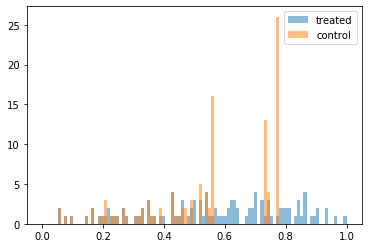

In [12]:
# matched control and treated
draw(ps_treated_list, ps_matched_control_list, bins1)

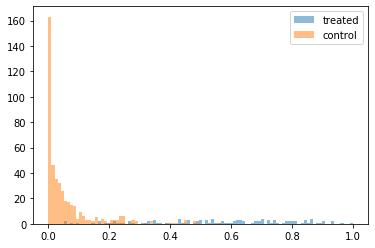

In [13]:
# unmatched control and treated
draw(ps_treated_list, ps_un_matched_control_list, bins1)

In [14]:
class GAN_Module:
    def __init__(self, discriminator_in_nodes, generator_out_nodes, device):
        self.discriminator = Discriminator(in_nodes=discriminator_in_nodes).to(device)
        self.discriminator.apply(self.weights_init)

        self.generator = Generator(out_nodes=generator_out_nodes).to(device)
        self.generator.apply(self.weights_init)

        self.loss = nn.BCELoss()

    def get_generator(self):
        return self.generator

    def __cal_propensity_loss(self, ps_score_control, prop_score_NN_model_path, gen_treated, device):
        # Assign treated
        Y = np.ones(gen_treated.size(0))
        eval_set = Utils.convert_to_tensor(gen_treated.detach().numpy(), Y)

        eval_parameters_ps_net = {
            "eval_set": eval_set,
            "model_path": prop_score_NN_model_path,
            "input_nodes": 25
        }
        ps_net_NN = Propensity_socre_network()
        ps_score_list_treated = ps_net_NN.eval(eval_parameters_ps_net, device,
                                               phase="eval",
                                               eval_from_GAN=True)

        Tensor = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
        ps_score_treated = Tensor(ps_score_list_treated)

        prop_loss = torch.sum((torch.sub(ps_score_treated, ps_score_control)) ** 2)
        return prop_loss

    def noise(self, _size):
        n = Variable(torch.normal(mean=0, std=1, size=(_size, 25)))
        # print(n.size())
        if torch.cuda.is_available(): return n.cuda()
        return n

    def weights_init(self, m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

    def real_data_target(self, size):
        '''
        Tensor containing ones, with shape = size
        '''
        data = Variable(torch.ones(size, 1))
        if torch.cuda.is_available(): return data.cuda()
        return data

    def fake_data_target(self, size):
        '''
        Tensor containing zeros, with shape = size
        '''
        data = Variable(torch.zeros(size, 1))
        if torch.cuda.is_available(): return data.cuda()
        return data

    def train_discriminator(self, optimizer, real_data, fake_data):
        # Reset gradients
        optimizer.zero_grad()

        # 1.1 Train on Real Data
        prediction_real = self.discriminator(real_data)
        real_score = torch.mean(prediction_real).item()
        
        # Calculate error and backpropagate
        error_real = self.loss(prediction_real, self.real_data_target(real_data.size(0)))
        error_real.backward()

        # 1.2 Train on Fake Data
        prediction_fake = self.discriminator(fake_data)
        fake_score = torch.mean(prediction_fake).item()
        # Calculate error and backpropagate
        error_fake = self.loss(prediction_fake, self.fake_data_target(real_data.size(0)))
        error_fake.backward()

        # 1.3 Update weights with gradients
        optimizer.step()
        loss_D = error_real + error_fake
        # Return error
        return loss_D.item(), real_score, fake_score

    def train_generator(self, optimizer, fake_data, ALPHA, ps_score_control,
                        prop_score_NN_model_path, device):
        # 2. Train Generator
        # Reset gradients
        optimizer.zero_grad()
        # Sample noise and generate fake data
        predicted_D = self.discriminator(fake_data)
        # Calculate error and back propagate
        error_g = self.loss(predicted_D, self.real_data_target(predicted_D.size(0)))
        prop_loss = self.__cal_propensity_loss(ps_score_control, prop_score_NN_model_path,
                                               fake_data, device)
        error = error_g + (ALPHA * prop_loss)
        error.backward()
        # Update weights with gradients
        optimizer.step()
        # Return error
        return error_g.item(), prop_loss.item()

    def train_GAN(self, train_parameters, device):
        epochs = train_parameters["epochs"]
        train_set = train_parameters["train_set"]
        lr = train_parameters["lr"]
        shuffle = train_parameters["shuffle"]
        batch_size = train_parameters["batch_size"]
        prop_score_NN_model_path = train_parameters["prop_score_NN_model_path"]
        ALPHA = train_parameters["ALPHA"]

        data_loader_train = torch.utils.data.DataLoader(train_set,
                                                        batch_size=batch_size,
                                                        shuffle=shuffle,
                                                        num_workers=1)

        #         generator = Generator(out_nodes=generator_out_nodes).to(device)
        #         discriminator = Discriminator(in_nodes=discriminator_in_nodes).to(device)

        g_optimizer = optim.Adam(self.generator.parameters(), lr=lr)
        d_optimizer = optim.Adam(self.discriminator.parameters(), lr=lr)

        for epoch in range(epochs):
            epoch += 1
#             self.generator.train()
#             self.discriminator.train()
            
            total_G_loss = 0
            total_D_loss = 0
            total_prop_loss = 0
            total_d_pred_real = 0
            total_d_pred_fake = 0

            for batch in data_loader_train:
                covariates_X_control, ps_score_control, y_f, y_cf = batch
                covariates_X_control = covariates_X_control.to(device)
                covariates_X_control_size = covariates_X_control.size(0)
                ps_score_control = ps_score_control.squeeze().to(device)

                # 1. Train Discriminator
                real_data = covariates_X_control
                # Generate fake data
                fake_data = self.generator(self.noise(covariates_X_control_size)).detach()
                # Train D
                d_error, d_pred_real, d_pred_fake = self.train_discriminator(d_optimizer,
                                                                             real_data, fake_data)
                total_D_loss += d_error
                total_d_pred_real += d_pred_real
                total_d_pred_fake += d_pred_fake

                # 2. Train Generator
                # Generate fake data
                fake_data = self.generator(self.noise(covariates_X_control_size))
                # Train G
                error_g, prop_loss = self.train_generator(g_optimizer, fake_data, ALPHA, ps_score_control,
                                                          prop_score_NN_model_path, device)
                total_G_loss += error_g
                total_prop_loss += prop_loss

            if epoch % 1000 == 0:
                print("Epoch: {0}, D_loss: {1}, D_score_real: {2}, D_score_Fake: {3}, G_loss: {4}, "
                      "Prop_loss: {5}"
                      .format(epoch,
                              total_D_loss, total_d_pred_real, total_d_pred_fake, total_G_loss, total_prop_loss))

In [15]:
# GAN Part from here
prop_score_NN_model_path = Constants.PROP_SCORE_NN_MODEL_PATH \
            .format(iter_id, Constants.PROP_SCORE_NN_EPOCHS, Constants.PROP_SCORE_NN_LR)
gan = GAN_Module(discriminator_in_nodes=25, generator_out_nodes=25, device=device)
GAN_train_parameters = {
            "epochs": 10000,
            "lr": 0.0002,
            "shuffle": True,
            "train_set": tensor_unmatched_control,
            "batch_size": 64,
            "prop_score_NN_model_path": prop_score_NN_model_path,
            "ALPHA": 1.2
}

gan.train_GAN(GAN_train_parameters, device=device)

Epoch: 1000, D_loss: 8.04822313785553, D_score_real: 4.229069471359253, D_score_Fake: 2.4143779575824738, G_loss: 8.230191707611084, Prop_loss: 30.502287797106
Epoch: 2000, D_loss: 5.547657370567322, D_score_real: 5.098188638687134, D_score_Fake: 1.7744233310222626, G_loss: 10.193827986717224, Prop_loss: 10.755319167336605
Epoch: 3000, D_loss: 5.450867235660553, D_score_real: 5.196991264820099, D_score_Fake: 1.6319672614336014, G_loss: 10.946046233177185, Prop_loss: 13.03755600979926
Epoch: 4000, D_loss: 4.557817459106445, D_score_real: 5.577185869216919, D_score_Fake: 1.518505498766899, G_loss: 10.830700993537903, Prop_loss: 5.46445472645753
Epoch: 5000, D_loss: 4.430369734764099, D_score_real: 5.595266401767731, D_score_Fake: 1.4090280383825302, G_loss: 11.39314091205597, Prop_loss: 5.396853944667522
Epoch: 6000, D_loss: 4.02604877948761, D_score_real: 5.735526740550995, D_score_Fake: 1.3572924137115479, G_loss: 11.903408408164978, Prop_loss: 5.337163867409228
Epoch: 7000, D_loss: 4.

In [16]:
def noise(_size):
        n = Variable(torch.normal(mean=0, std=1, size=(_size, 25)))
        # print(n.size())
        if torch.cuda.is_available(): return n.cuda()
        return n
    
def eval_GAN(eval_size, generator, device):
    treated_g = generator(noise(eval_size))
    return treated_g

In [17]:
eval_size = len(unmatched_control_indices)
gen_net = gan.get_generator()
treated_generated = eval_GAN(eval_size, gen_net, device)
print("eval_size: " + str(eval_size))
print("Treated G size")
print(treated_generated.size())

eval_size: 447
Treated G size
torch.Size([447, 25])


In [18]:
Y = np.ones(treated_generated.size(0))
eval_set = Utils.convert_to_tensor(treated_generated.detach().numpy(), Y)
eval_parameters_ps_net = {
            "eval_set": eval_set,
            "model_path": prop_score_NN_model_path,
            "input_nodes": 25
}
ps_net_NN = Propensity_socre_network()
ps_score_list_treated = ps_net_NN.eval(eval_parameters_ps_net, device,
                                        phase="eval", eval_from_GAN=True)

len(ps_score_list_treated)

447

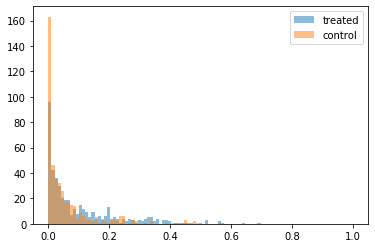

In [19]:
# treated by GAN vs unmactched control
draw(ps_score_list_treated, ps_un_matched_control_list, bins1)

In [20]:
epochs = 100
lr = 0.001

In [21]:
def execute_DCN_train(tensor_treated_train, tensor_control_train, model_path, iter_id,
                            input_nodes, device, train_mode):
    DCN_train_parameters = {
                "epochs": epochs,
                "lr": lr,
                "treated_batch_size": 1,
                "control_batch_size": 1,
                "shuffle": True,
                "treated_set_train": tensor_treated_train,
                "control_set_train": tensor_control_train,
                "model_save_path": model_path.format(iter_id,
                                                     epochs,
                                                     lr),
                "input_nodes": input_nodes
    }

            # train DCN network
    dcn = DCN_network_1()
    dcn.train(DCN_train_parameters, device, train_mode=train_mode)

In [32]:
print("### DCN semi supervised training using PS Matching No PD###")



model_path_no_dropout = "./DCNModel/NN_DCN_SEMI_SUPERVISED_NO_DROPOUT_PM_MATCH_FALSE_model_iter_id_{0}_epoch_{1}_lr_{2}.pth"
train_mode = Constants.DCN_TRAIN_NO_DROPOUT
execute_DCN_train(tensor_treated, 
                  tensor_matched_control, 
                  model_path_no_dropout, iter_id,
                input_nodes, device, train_mode)

# t_treated = Utils.create_tensors_to_train_DCN(data_loader_dict_train["treated_data"], dL)
# t_control =  Utils.create_tensors_to_train_DCN(data_loader_dict_train["control_data"], dL)


# train_mode = Constants.DCN_TRAIN_PD
# execute_DCN_train(t_treated, 
#                   t_control, 
#                   model_path_no_dropout, 
#                   iter_id,
#                   input_nodes, 
#                   device, 
#                   train_mode)

### DCN semi supervised training using PS Matching No PD###
Saved model path: ./DCNModel/NN_DCN_SEMI_SUPERVISED_NO_DROPOUT_PM_MATCH_FALSE_model_iter_id_10_epoch_100_lr_0.001.pth
.. Training started ..
cpu
epoch: 9, Treated + Control loss: 116.94579231196622
epoch: 19, Treated + Control loss: 35.21253450181757
epoch: 29, Treated + Control loss: 59.59191041842729
epoch: 39, Treated + Control loss: 24.2423763605085
epoch: 49, Treated + Control loss: 18.771584004244062
epoch: 59, Treated + Control loss: 4.259756335868133
epoch: 69, Treated + Control loss: 73.15056561124649
epoch: 79, Treated + Control loss: 3.4450513626997576
epoch: 89, Treated + Control loss: 22.161050639135453
epoch: 99, Treated + Control loss: 75.35371143297266


In [33]:
## to be added in the code
def convert_to_tensor_DCN_PS(tensor_x, ps_score):
    tensor_ps_score = torch.from_numpy(ps_score)
    # tensor_x = torch.stack([torch.Tensor(i) for i in X])
    processed_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_ps_score)
    return processed_dataset

def eval_semi_supervised(eval_parameters, device, input_nodes, train_mode, treated_flag):
    eval_set = eval_parameters["eval_set"]
    model_path = eval_parameters["model_save_path"]
    network = DCN(training_mode=train_mode, input_nodes=input_nodes).to(device)
    network.load_state_dict(torch.load(model_path, map_location=device))
    network.eval()
    treated_data_loader = torch.utils.data.DataLoader(eval_set,
                                                          shuffle=False, num_workers=1)
    
    y_f_list = []
    y_cf_list = []

    for batch in treated_data_loader:
        covariates_X, ps_score = batch
        covariates_X = covariates_X.to(device)
        ps_score = ps_score.squeeze().to(device)
        treatment_pred = network(covariates_X, ps_score)
        if treated_flag:
            y_f_list.append(treatment_pred[0].item())
            y_cf_list.append(treatment_pred[1].item())
        else:
            y_f_list.append(treatment_pred[1].item())
            y_cf_list.append(treatment_pred[0].item())
        # print(err_treated_list)
        # print(err_control_list)
    return {
            "y_f_list": np.array(y_f_list),
            "y_cf_list": np.array(y_cf_list)
    }

In [34]:
ps_score_list_treated_np = np.array(ps_score_list_treated)
eval_set = convert_to_tensor_DCN_PS(treated_generated.detach(), ps_score_list_treated_np)

DCN_test_parameters = {
            "eval_set": eval_set,
            "model_save_path": model_path_no_dropout.format(iter_id,
                    epochs,
                    lr)
}
treated_gen_y = eval_semi_supervised(DCN_test_parameters, device, input_nodes,
                                 Constants.DCN_EVALUATION, treated_flag=True)

In [35]:
np_treated_generated = treated_generated.detach().numpy()
np_ps_score_list_gen_treated = ps_score_list_treated_np
np_treated_gen_f = Utils.convert_to_col_vector(treated_gen_y["y_f_list"])
np_treated_gen_cf = Utils.convert_to_col_vector(treated_gen_y["y_cf_list"])

print(np_treated_gen_f.shape)

np_original_X = tuple_treated[0]
np_original_ps_score = tuple_treated[1]
np_original_Y_f = tuple_treated[2]
np_original_Y_cf = tuple_treated[3]

print(np_original_Y_f.shape)

np_treated_x = np.concatenate((np_treated_generated, np_original_X), axis=0)
np_treated_ps = np.concatenate((np_ps_score_list_gen_treated, np_original_ps_score), axis=0)
np_treated_f = np.concatenate((np_treated_gen_f, np_original_Y_f), axis=0)
np_treated_cf = np.concatenate((np_treated_gen_cf, np_original_Y_cf), axis=0)

tensor_treated = Utils.convert_to_tensor_DCN(np_treated_x, np_treated_ps,
                                            np_treated_f, np_treated_cf)

np_treated_x.shape



(447, 1)
(112, 1)


(559, 25)

In [36]:
np_control_unmatched_X = tuple_unmatched_control[0]
np_ps_score_list_control_unmatched = tuple_unmatched_control[1]
np_control_unmatched_f = tuple_unmatched_control[2]
np_control_unmatched_cf = tuple_unmatched_control[3]

np_control_matched_X = tuple_matched_control[0]
np_ps_score_list_control_matched = tuple_matched_control[1]
np_control_matched_f = tuple_matched_control[2]
np_control_matched_cf = tuple_matched_control[3]

print(np_control_unmatched_cf.shape)
print(np_control_matched_cf.shape)

np_control_x = np.concatenate((np_control_unmatched_X, np_control_matched_X), axis=0)
np_control_ps = np.concatenate((np_ps_score_list_control_unmatched, np_ps_score_list_control_matched), axis=0)
np_control_f = np.concatenate((np_control_unmatched_f, np_control_matched_f), axis=0)
np_control_cf = np.concatenate((np_control_unmatched_cf, np_control_matched_cf), axis=0)

tensor_control = Utils.convert_to_tensor_DCN(np_control_x, np_control_ps,
                                            np_control_f, np_control_cf)


np_control_x.shape

(447, 1)
(112, 1)


(559, 25)

In [ ]:
tuple_control_train = (np_control_x, np_control_ps, np_control_f, np_control_cf)
tuple_treated_train = (np_treated_x, np_treated_ps, np_treated_f, np_treated_cf)


In [37]:
print("### DCN training using all dataset no PD ###")

train_mode = Constants.DCN_TRAIN_NO_DROPOUT

model_path = "./DCNModel/NN_DCN_NO_DROPOUT_PM_MATCH_FALSE_model_iter_id_{0}_epoch_{1}_lr_{2}.pth"

execute_DCN_train(tensor_treated, 
                  tensor_control, 
                  model_path, 
                  iter_id,
                  input_nodes, 
                  device, 
                  train_mode)



### DCN training using all dataset no PD ###
Saved model path: ./DCNModel/NN_DCN_NO_DROPOUT_PM_MATCH_FALSE_model_iter_id_10_epoch_100_lr_0.001.pth
.. Training started ..
cpu
epoch: 9, Treated + Control loss: 707.8079475988322
epoch: 19, Treated + Control loss: 467.26298138267475
epoch: 29, Treated + Control loss: 320.09224322317664
epoch: 39, Treated + Control loss: 237.40315885586529
epoch: 49, Treated + Control loss: 137.67990073766123
epoch: 59, Treated + Control loss: 94.7723870317252
epoch: 69, Treated + Control loss: 105.38134943241832
epoch: 79, Treated + Control loss: 81.92853258633221
epoch: 89, Treated + Control loss: 59.7053548837828
epoch: 99, Treated + Control loss: 59.37603156465383


In [39]:
# testing
print("----------- Testing phase ------------")
dL = DataLoader()
ps_test_set = dL.convert_to_tensor(np_covariates_X_test,
                                           np_covariates_Y_test)

is_synthetic = False
input_nodes = 25

        # get propensity scores using NN
ps_net_NN = Propensity_socre_network()
ps_eval_parameters_NN = {
            "eval_set": ps_test_set,
            "model_path": Constants.PROP_SCORE_NN_MODEL_PATH
                .format(iter_id, Constants.PROP_SCORE_NN_EPOCHS, Constants.PROP_SCORE_NN_LR),
            "input_nodes": input_nodes
}
ps_score_list_NN = ps_net_NN.eval(ps_eval_parameters_NN, device, phase="eval")

data_loader_dict = dL.prepare_tensor_for_DCN(np_covariates_X_test,
                                                        np_covariates_Y_test,
                                                        ps_score_list_NN,
                                                        is_synthetic)

model_path = model_path.format(iter_id,
                    epochs,
                    lr)

print(model_path)
treated_group = data_loader_dict["treated_data"]
np_treated_df_X = treated_group[0]
np_treated_ps_score = treated_group[1]
np_treated_df_Y_f = treated_group[2]
np_treated_df_Y_cf = treated_group[3]
tensor_treated = Utils.convert_to_tensor_DCN(np_treated_df_X, np_treated_ps_score,
                                                     np_treated_df_Y_f, np_treated_df_Y_cf)

control_group = data_loader_dict["control_data"]
np_control_df_X = control_group[0]
np_control_ps_score = control_group[1]
np_control_df_Y_f = control_group[2]
np_control_df_Y_cf = control_group[3]
tensor_control = Utils.convert_to_tensor_DCN(np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f, np_control_df_Y_cf)

DCN_test_parameters = {
            "treated_set": tensor_treated,
            "control_set": tensor_control,
            "model_save_path": model_path
}

dcn = DCN_network_1()
response_dict = dcn.eval(DCN_test_parameters, device, input_nodes,
                                 Constants.DCN_EVALUATION)
err_treated = [ele ** 2 for ele in response_dict["treated_err"]]
err_control = [ele ** 2 for ele in response_dict["control_err"]]

total_sum = sum(err_treated) + sum(err_control)
total_item = len(err_treated) + len(err_control)
MSE = total_sum / total_item

print("PSM")
print(MSE)

----------- Testing phase ------------
 Treated Statistics ==>
(27, 25)
 Control Statistics ==>
(123, 25)
./DCNModel/NN_DCN_NO_DROPOUT_PM_MATCH_FALSE_model_iter_id_10_epoch_100_lr_0.001.pth
PSM
2.3053911928931794


In [29]:
print("### DCN training using all dataset DCN PD ###")

train_mode = Constants.DCN_TRAIN_PD

model_path = "./DCNModel/DCN_PD_model_iter_id_{0}_epoch_{1}_lr_{2}.pth"
t_treated = Utils.create_tensors_to_train_DCN(data_loader_dict_train["treated_data"], dL)
t_control =  Utils.create_tensors_to_train_DCN(data_loader_dict_train["control_data"], dL)

execute_DCN_train(t_treated, 
                  t_control, 
                  model_path, 
                  iter_id,
                  input_nodes, 
                  device, 
                  train_mode)

### DCN training using all dataset DCN PD ###
Saved model path: ./DCNModel/DCN_PD_model_iter_id_10_epoch_100_lr_0.001.pth
.. Training started ..
cpu
epoch: 9, Treated + Control loss: 1001.0237502176751
epoch: 19, Treated + Control loss: 821.8525736710048
epoch: 29, Treated + Control loss: 824.4688989928818
epoch: 39, Treated + Control loss: 718.0689708249702
epoch: 49, Treated + Control loss: 665.4653844915052
epoch: 59, Treated + Control loss: 600.6444613171188
epoch: 69, Treated + Control loss: 570.2974571891214
epoch: 79, Treated + Control loss: 723.323639266355
epoch: 89, Treated + Control loss: 516.2083776923175
epoch: 99, Treated + Control loss: 454.3476396009885


In [30]:
# testing
print("----------- Testing phase ------------")
dL = DataLoader()
ps_test_set = dL.convert_to_tensor(np_covariates_X_test,
                                           np_covariates_Y_test)

is_synthetic = False
input_nodes = 25

        # get propensity scores using NN
ps_net_NN = Propensity_socre_network()
ps_eval_parameters_NN = {
            "eval_set": ps_test_set,
            "model_path": Constants.PROP_SCORE_NN_MODEL_PATH
                .format(iter_id, Constants.PROP_SCORE_NN_EPOCHS, Constants.PROP_SCORE_NN_LR),
            "input_nodes": input_nodes
}
ps_score_list_NN = ps_net_NN.eval(ps_eval_parameters_NN, device, phase="eval")

data_loader_dict = dL.prepare_tensor_for_DCN(np_covariates_X_test,
                                                        np_covariates_Y_test,
                                                        ps_score_list_NN,
                                                        is_synthetic)

model_path = model_path.format(iter_id,
                    epochs,
                    lr)

print(model_path)
treated_group = data_loader_dict["treated_data"]
np_treated_df_X = treated_group[0]
np_treated_ps_score = treated_group[1]
np_treated_df_Y_f = treated_group[2]
np_treated_df_Y_cf = treated_group[3]
tensor_treated = Utils.convert_to_tensor_DCN(np_treated_df_X, np_treated_ps_score,
                                                     np_treated_df_Y_f, np_treated_df_Y_cf)

control_group = data_loader_dict["control_data"]
np_control_df_X = control_group[0]
np_control_ps_score = control_group[1]
np_control_df_Y_f = control_group[2]
np_control_df_Y_cf = control_group[3]
tensor_control = Utils.convert_to_tensor_DCN(np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f, np_control_df_Y_cf)

DCN_test_parameters = {
            "treated_set": tensor_treated,
            "control_set": tensor_control,
            "model_save_path": model_path
}

dcn = DCN_network_1()
response_dict = dcn.eval(DCN_test_parameters, device, input_nodes,
                                 Constants.DCN_EVALUATION)
err_treated = [ele ** 2 for ele in response_dict["treated_err"]]
err_control = [ele ** 2 for ele in response_dict["control_err"]]

total_sum = sum(err_treated) + sum(err_control)
total_item = len(err_treated) + len(err_control)
MSE = total_sum / total_item
print("DCN_PD")
print(MSE)

----------- Testing phase ------------
 Treated Statistics ==>
(27, 25)
 Control Statistics ==>
(123, 25)
./DCNModel/DCN_PD_model_iter_id_10_epoch_100_lr_0.001.pth
DCN_PD
2.6120958867727557


# TARNET

In [44]:
class TARNetPhi(nn.Module):
    def __init__(self, input_nodes, shared_nodes=200):
        super(TARNetPhi, self).__init__()

        # shared layer
        self.shared1 = nn.Linear(in_features=input_nodes, out_features=shared_nodes)
        nn.init.xavier_uniform_(self.shared1.weight)
        nn.init.zeros_(self.shared1.bias)

        self.shared2 = nn.Linear(in_features=shared_nodes, out_features=shared_nodes)
        nn.init.xavier_uniform_(self.shared2.weight)
        nn.init.zeros_(self.shared2.bias)

        self.shared3 = nn.Linear(in_features=shared_nodes, out_features=shared_nodes)
        nn.init.xavier_uniform_(self.shared3.weight)
        nn.init.zeros_(self.shared3.bias)

    def forward(self, x):
        if torch.cuda.is_available():
            x = x.float().cuda()
        else:
            x = x.float()
        # shared layers
        x = F.relu(self.shared1(x))
        x = F.relu(self.shared2(x))
        x = F.relu(self.shared3(x))

        return x


class TARNetH_Y1(nn.Module):
    def __init__(self, input_nodes=200, outcome_nodes=100):
        super(TARNetH_Y1, self).__init__()

        # potential outcome1 Y(1)
        self.hidden1_Y1 = nn.Linear(in_features=input_nodes, out_features=outcome_nodes)
        nn.init.xavier_uniform_(self.hidden1_Y1.weight)
        nn.init.zeros_(self.hidden1_Y1.bias)

        self.hidden2_Y1 = nn.Linear(in_features=outcome_nodes, out_features=outcome_nodes)
        nn.init.xavier_uniform_(self.hidden2_Y1.weight)
        nn.init.zeros_(self.hidden2_Y1.bias)

        self.out_Y1 = nn.Linear(in_features=outcome_nodes, out_features=1)
        nn.init.xavier_uniform_(self.out_Y1.weight)
        nn.init.zeros_(self.out_Y1.bias)

    def forward(self, x):
        if torch.cuda.is_available():
            x = x.float().cuda()
        else:
            x = x.float()

        # potential outcome1 Y(1)
        y1 = F.relu(self.hidden1_Y1(x))
        y1 = F.relu(self.hidden2_Y1(y1))
        y1 = self.out_Y1(y1)

        return y1


class TARNetH_Y0(nn.Module):
    def __init__(self, input_nodes=200, outcome_nodes=100):
        super(TARNetH_Y0, self).__init__()

        # potential outcome1 Y(0)
        self.hidden1_Y0 = nn.Linear(in_features=input_nodes, out_features=outcome_nodes)
        nn.init.xavier_uniform_(self.hidden1_Y0.weight)
        nn.init.zeros_(self.hidden1_Y0.bias)

        self.hidden2_Y0 = nn.Linear(in_features=outcome_nodes, out_features=outcome_nodes)
        nn.init.xavier_uniform_(self.hidden2_Y0.weight)
        nn.init.zeros_(self.hidden2_Y0.bias)

        self.out_Y0 = nn.Linear(in_features=outcome_nodes, out_features=1)
        nn.init.xavier_uniform_(self.out_Y0.weight)
        nn.init.zeros_(self.out_Y0.bias)

    def forward(self, x):
        if torch.cuda.is_available():
            x = x.float().cuda()
        else:
            x = x.float()

        # potential outcome1 Y(0)
        y0 = F.relu(self.hidden1_Y0(x))
        y0 = F.relu(self.hidden2_Y0(y0))
        y0 = self.out_Y0(y0)

        return y0



In [45]:
class PS_Matching:
    def match_using_prop_score(self, tuple_treated, tuple_control):
        matched_controls = []

        # do ps match
        np_treated_df_X, np_treated_ps_score, np_treated_df_Y_f, np_treated_df_Y_cf = tuple_treated
        np_control_df_X, np_control_ps_score, np_control_df_Y_f, np_control_df_Y_cf = tuple_control

        # get unmatched controls
        matched_control_indices, unmatched_control_indices = self.get_matched_and_unmatched_control_indices(
            Utils.convert_to_col_vector(np_treated_ps_score),
            Utils.convert_to_col_vector(np_control_ps_score))

        tuple_matched_control, tuple_unmatched_control = self.filter_matched_and_unmatched_control_samples(
            np_control_df_X, np_control_ps_score,
            np_control_df_Y_f,
            np_control_df_Y_cf, matched_control_indices,
            unmatched_control_indices)

        return tuple_matched_control

    def filter_matched_and_unmatched_control_samples(self, np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f,
                                                     np_control_df_Y_cf, matched_control_indices,
                                                     unmatched_control_indices):
        tuple_matched_control = self.filter_control_groups(np_control_df_X, np_control_ps_score,
                                                           np_control_df_Y_f,
                                                           np_control_df_Y_cf,
                                                           matched_control_indices)

        tuple_unmatched_control = self.filter_control_groups(np_control_df_X, np_control_ps_score,
                                                             np_control_df_Y_f,
                                                             np_control_df_Y_cf,
                                                             unmatched_control_indices)

        return tuple_matched_control, tuple_unmatched_control

    @staticmethod
    def filter_control_groups(np_control_df_X, np_control_ps_score,
                              np_control_df_Y_f,
                              np_control_df_Y_cf, indices):
        np_filter_control_df_X = np.take(np_control_df_X, indices, axis=0)
        np_filter_control_ps_score = np.take(np_control_ps_score, indices, axis=0)
        np_filter_control_df_Y_f = np.take(np_control_df_Y_f, indices, axis=0)
        np_filter_control_df_Y_cf = np.take(np_control_df_Y_cf, indices, axis=0)
        tuple_matched_control = (np_filter_control_df_X, np_filter_control_ps_score,
                                 np_filter_control_df_Y_f, np_filter_control_df_Y_cf)

        return tuple_matched_control

    @staticmethod
    def get_matched_and_unmatched_control_indices(ps_treated, ps_control):
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(ps_control)
        distance, matched_control = nn.kneighbors(ps_treated)
        matched_control_indices = np.array(matched_control).ravel()

        # remove duplicates
        # matched_control_indices = list(dict.fromkeys(matched_control_indices))
        set_matched_control_indices = set(matched_control_indices)
        total_indices = list(range(len(ps_control)))
        unmatched_control_indices = list(filter(lambda x: x not in set_matched_control_indices,
                                                total_indices))

        return matched_control_indices, unmatched_control_indices

    @staticmethod
    def get_unmatched_prop_list(tensor_unmatched_control):
        control_data_loader_train = torch.utils.data.DataLoader(tensor_unmatched_control,
                                                                batch_size=1,
                                                                shuffle=False,
                                                                num_workers=1)
        ps_unmatched_control_list = []
        for batch in control_data_loader_train:
            covariates_X, ps_score, y_f, y_cf = batch
            ps_unmatched_control_list.append(ps_score.item())

        return ps_unmatched_control_list

In [46]:
class InferenceNet:
    def __init__(self, input_nodes, shared_nodes, outcome_nodes, device):
        self.tarnet_phi = TARNetPhi(input_nodes, shared_nodes=shared_nodes).to(device)

        self.tarnet_h_y1 = TARNetH_Y1(input_nodes=shared_nodes,
                                      outcome_nodes=outcome_nodes).to(device)

        self.tarnet_h_y0 = TARNetH_Y0(input_nodes=shared_nodes,
                                      outcome_nodes=outcome_nodes).to(device)

    def get_tarnet_phi(self):
        return self.tarnet_phi

    def get_tarnet_h_y1(self):
        return self.tarnet_h_y1

    def get_tarnet_h_y0_model(self):
        return self.tarnet_h_y0

    def train(self, train_parameters, device):
        epochs = train_parameters["epochs"]
        batch_size = train_parameters["batch_size"]
        lr = train_parameters["lr"]
        weight_decay = train_parameters["lambda"]
        shuffle = train_parameters["shuffle"]
        treated_tensor_dataset = train_parameters["treated_tensor_dataset"]
        tuple_control = train_parameters["tuple_control_train"]

        treated_data_loader_train = torch.utils.data.DataLoader(treated_tensor_dataset,
                                                                batch_size=batch_size,
                                                                shuffle=shuffle,
                                                                num_workers=1)

        optimizer_W = optim.Adam(self.tarnet_phi.parameters(), lr=lr)
        optimizer_V1 = optim.Adam(self.tarnet_h_y1.parameters(), lr=lr, weight_decay=weight_decay)
        optimizer_V2 = optim.Adam(self.tarnet_h_y0.parameters(), lr=lr, weight_decay=weight_decay)
        lossF = nn.MSELoss()
        print(".. Training started ..")
        print(device)
        for epoch in range(epochs):
            epoch += 1
            total_loss_T = 0
            total_loss_C = 0
            for batch in treated_data_loader_train:
                covariates_X_treated, ps_score_treated, y_f_treated, y_cf_treated = batch
                covariates_X_treated = covariates_X_treated.to(device)
                ps_score_treated = ps_score_treated.squeeze().to(device)

                _tuple_treated = self.get_np_tuple_from_tensor(covariates_X_treated, ps_score_treated,
                                                               y_f_treated, y_cf_treated)
                psm = PS_Matching()
                tuple_matched_control = psm.match_using_prop_score(_tuple_treated, tuple_control)

                covariates_X_control, ps_score_control, y_f_control, y_cf_control = \
                    self.get_tensor_from_np_tuple(tuple_matched_control)

                y1_hat = self.tarnet_h_y1(self.tarnet_phi(covariates_X_treated))
                y0_hat = self.tarnet_h_y0(self.tarnet_phi(covariates_X_treated))

                if torch.cuda.is_available():
                    loss_T = lossF(y1_hat.float().cuda(),
                                   y_f_treated.float().cuda()).to(device)
                    loss_C = lossF(y0_hat.float().cuda(),
                                   y_f_control.float().cuda()).to(device)
                else:
                    loss_T = lossF(y1_hat.float(),
                                   y_f_treated.float()).to(device)
                    loss_C = lossF(y0_hat.float(),
                                   y_f_control.float()).to(device)

                optimizer_W.zero_grad()
                optimizer_V1.zero_grad()
                optimizer_V2.zero_grad()
                loss_T.backward()
                loss_C.backward()
                optimizer_W.step()
                optimizer_V1.step()
                optimizer_V2.step()
                total_loss_T += loss_T.item()
                total_loss_C += loss_C.item()

            if epoch % 100 == 0:
                print("epoch: {0}, Treated + Control loss: {1}".format(epoch, total_loss_T + total_loss_C))

    def eval(self, eval_parameters, device):
        treated_set = eval_parameters["treated_set"]
        control_set = eval_parameters["control_set"]
        treated_data_loader = torch.utils.data.DataLoader(treated_set,
                                                          shuffle=False, num_workers=1)
        control_data_loader = torch.utils.data.DataLoader(control_set,
                                                          shuffle=False, num_workers=1)

        err_treated_list = []
        err_control_list = []
        true_ITE_list = []
        predicted_ITE_list = []

        ITE_dict_list = []

        for batch in treated_data_loader:
            covariates_X, ps_score, y_f, y_cf = batch
            covariates_X = covariates_X.to(device)
            y1_hat = self.tarnet_h_y1(self.tarnet_phi(covariates_X))
            y0_hat = self.tarnet_h_y0(self.tarnet_phi(covariates_X))

            predicted_ITE = y1_hat - y0_hat
            true_ITE = y_f - y_cf

            if torch.cuda.is_available():
                diff = true_ITE.float().cuda() - predicted_ITE.float().cuda()
            else:
                diff = true_ITE.float() - predicted_ITE.float()

            # ITE_dict_list.append(self.create_ITE_Dict(covariates_X,
            #                                           ps_score.item(), y_f.item(),
            #                                           y_cf.item(),
            #                                           true_ITE.item(),
            #                                           predicted_ITE.item(),
            #                                           diff.item()))
            err_treated_list.append(diff.item())
            true_ITE_list.append(true_ITE.item())
            predicted_ITE_list.append(predicted_ITE.item())

        for batch in control_data_loader:
            covariates_X, ps_score, y_f, y_cf = batch
            covariates_X = covariates_X.to(device)

            y1_hat = self.tarnet_h_y1(self.tarnet_phi(covariates_X))
            y0_hat = self.tarnet_h_y0(self.tarnet_phi(covariates_X))

            predicted_ITE = y1_hat - y0_hat
            true_ITE = y_cf - y_f
            if torch.cuda.is_available():
                diff = true_ITE.float().cuda() - predicted_ITE.float().cuda()
            else:
                diff = true_ITE.float() - predicted_ITE.float()

            # ITE_dict_list.append(self.create_ITE_Dict(covariates_X,
            #                                           ps_score.item(), y_f.item(),
            #                                           y_cf.item(),
            #                                           true_ITE.item(),
            #                                           predicted_ITE.item(),
            #                                           diff.item()))
            err_control_list.append(diff.item())
            true_ITE_list.append(true_ITE.item())
            predicted_ITE_list.append(predicted_ITE.item())

        # print(err_treated_list)
        # print(err_control_list)
        return {
            "treated_err": err_treated_list,
            "control_err": err_control_list,
            "true_ITE": true_ITE_list,
            "predicted_ITE": predicted_ITE_list,
            "ITE_dict_list": ITE_dict_list
        }

    @staticmethod
    def get_np_tuple_from_tensor(covariates_X, ps_score, y_f, y_cf):
        np_covariates_X = covariates_X.numpy()
        ps_score = ps_score.numpy()
        y_f = y_f.numpy()
        y_cf = y_cf.numpy()
        _tuple = (np_covariates_X, ps_score, y_f, y_cf)

        return _tuple

    @staticmethod
    def get_tensor_from_np_tuple(_tuple):
        np_df_X, np_ps_score, np_df_Y_f, np_df_Y_cf = _tuple
        return torch.from_numpy(np_df_X), torch.from_numpy(np_ps_score), \
               torch.from_numpy(np_df_Y_f), torch.from_numpy(np_df_Y_cf),

In [49]:
tuple_control_train = (np_control_x, np_control_ps, np_control_f, np_control_cf)
tuple_treated_train = (np_treated_x, np_treated_ps, np_treated_f, np_treated_cf)

print("Actual Sizes")
print(np_treated_x.shape)
print(np_control_x.shape)

tensor_treated = Utils.convert_to_tensor_DCN(np_treated_x, np_treated_ps,
                                            np_treated_f, np_treated_cf)

train_parameters = {
                "epochs": 100,
                "lr": 1e-3,
                "lambda":1e-4,
                "batch_size": 32,
                "shuffle": True,
                "treated_tensor_dataset": tensor_treated,
                "tuple_control_train": tuple_control_train
    }

inference = InferenceNet(input_nodes=25, shared_nodes=200, 
                         outcome_nodes=100,
                         device=device)

inference.train(train_parameters, device)

Actual Sizes
(559, 25)
(559, 25)
.. Training started ..
cpu
epoch: 100, Treated + Control loss: 11.158835638314486


In [50]:
# testing
print("----------- Testing phase ------------")
dL = DataLoader()
ps_test_set = dL.convert_to_tensor(np_covariates_X_test,
                                           np_covariates_Y_test)

is_synthetic = False
input_nodes = 25

        # get propensity scores using NN
ps_net_NN = Propensity_socre_network()
ps_eval_parameters_NN = {
            "eval_set": ps_test_set,
            "model_path": Constants.PROP_SCORE_NN_MODEL_PATH
                .format(iter_id, Constants.PROP_SCORE_NN_EPOCHS, Constants.PROP_SCORE_NN_LR),
            "input_nodes": input_nodes
}
ps_score_list_NN = ps_net_NN.eval(ps_eval_parameters_NN, device, phase="eval")

data_loader_dict = dL.prepare_tensor_for_DCN(np_covariates_X_test,
                                                        np_covariates_Y_test,
                                                        ps_score_list_NN,
                                                        is_synthetic)

model_path = model_path.format(iter_id,
                    epochs,
                    lr)

print(model_path)
treated_group = data_loader_dict["treated_data"]
np_treated_df_X = treated_group[0]
np_treated_ps_score = treated_group[1]
np_treated_df_Y_f = treated_group[2]
np_treated_df_Y_cf = treated_group[3]
tensor_treated = Utils.convert_to_tensor_DCN(np_treated_df_X, np_treated_ps_score,
                                                     np_treated_df_Y_f, np_treated_df_Y_cf)

control_group = data_loader_dict["control_data"]
np_control_df_X = control_group[0]
np_control_ps_score = control_group[1]
np_control_df_Y_f = control_group[2]
np_control_df_Y_cf = control_group[3]
tensor_control = Utils.convert_to_tensor_DCN(np_control_df_X, np_control_ps_score,
                                                     np_control_df_Y_f, np_control_df_Y_cf)

print(np_treated_df_X.shape)
print(np_control_df_X.shape)

test_parameters = {
            "treated_set": tensor_treated,
            "control_set": tensor_control
}

response_dict = inference.eval(test_parameters, device)
err_treated = [ele ** 2 for ele in response_dict["treated_err"]]
err_control = [ele ** 2 for ele in response_dict["control_err"]]

total_sum = sum(err_treated) + sum(err_control)
total_item = len(err_treated) + len(err_control)
MSE = total_sum / total_item

print("Testing using Inference")
print(MSE)

----------- Testing phase ------------
 Treated Statistics ==>
(27, 25)
 Control Statistics ==>
(123, 25)
./DCNModel/NN_DCN_NO_DROPOUT_PM_MATCH_FALSE_model_iter_id_10_epoch_100_lr_0.001.pth
(27, 25)
(123, 25)
Testing using Inference
6.906225153709756
